## 1. import modules

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # matplotlib와 같이쓰면 prettier 가능
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## 2. read train data

In [129]:
data = pd.read_csv('./titanic/train.csv')

In [130]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [131]:
data.isnull().sum() # count total null values, 'Age' and 'Cabin' is missed

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [132]:
data.count() # count not null values

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [133]:
data.shape # 891 rows

(891, 12)

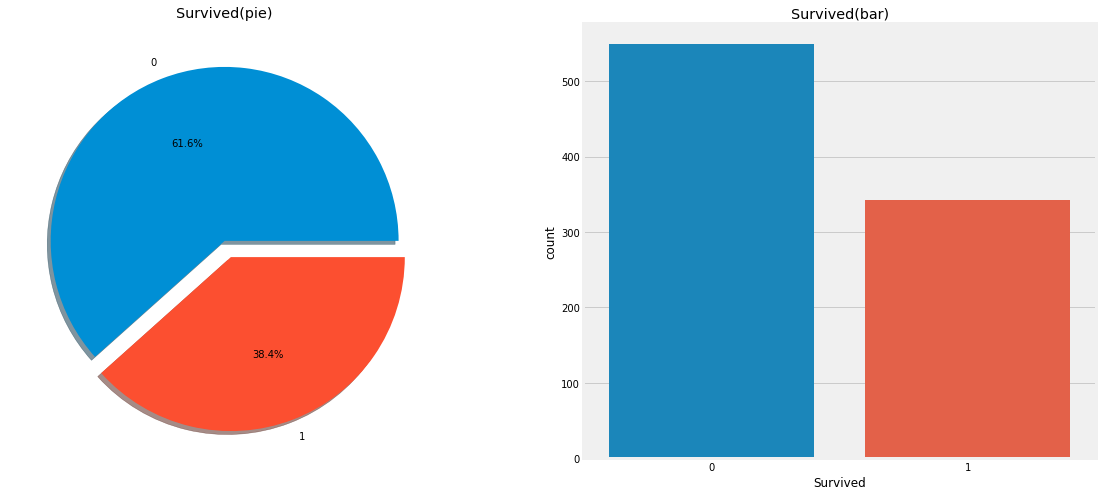

total: 891 dead: 549 survived: 342


In [134]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],
                                         autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived(pie)')
ax[0].set_ylabel('')
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived(bar)')
plt.show()
dead, survived = data['Survived'].value_counts()
print('total:', dead+survived, 'dead:', dead, 'survived:', survived)

## 3. Analyzing The Features
- Sex, Embark => categorical
- PClass, SibSp, Parch => ordinal
- Age, Fare => continuous

In [135]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

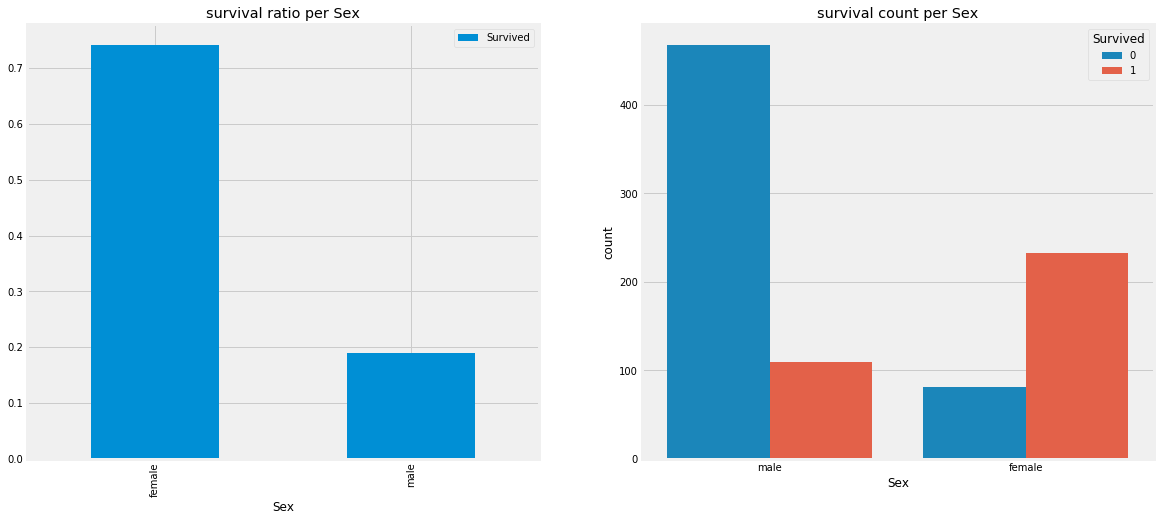

In [136]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
data[['Sex', 'Survived']].groupby('Sex').mean().plot.bar(ax=ax[0])
ax[0].set_title('survival ratio per Sex')
sns.countplot('Sex', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('survival count per Sex')
plt.show()

It seems that female was survived much

In [137]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient()

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


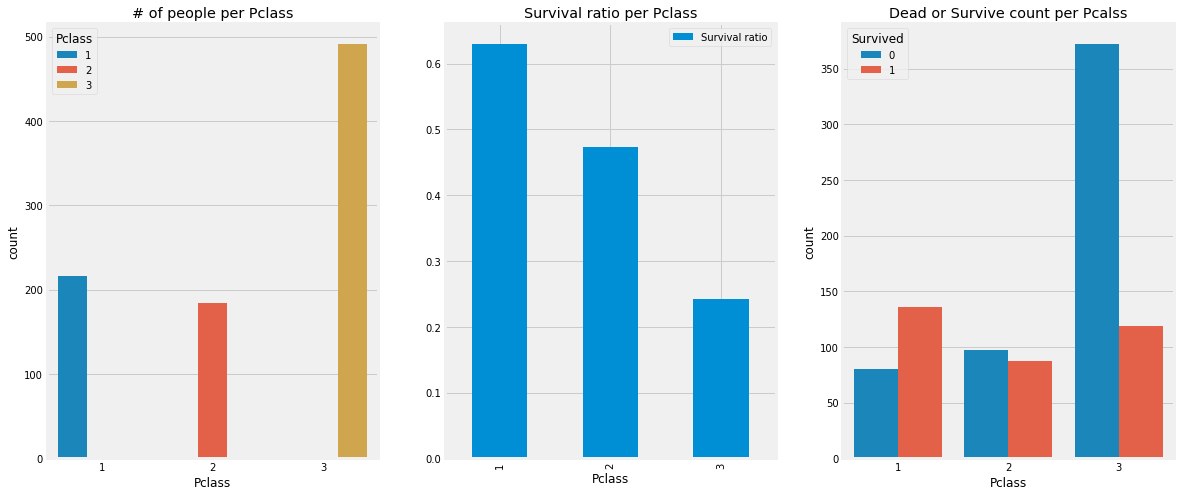

In [138]:
f, ax = plt.subplots(1, 3, figsize=(18, 8))
ax[0].set_title('# of people per Pclass')
sns.countplot('Pclass', data=data, hue='Pclass', ax=ax[0])

ax[1].set_title('Survival ratio per Pclass')
data[['Survived', 'Pclass']].groupby('Pclass').mean().plot.bar(ax=ax[1])
ax[1].legend(['Survival ratio'])

ax[2].set_title('Dead or Survive count per Pcalss')
sns.countplot('Pclass', hue='Survived', data=data, ax=ax[2])
plt.show()

Rich people survived well than poor people!!!

In [139]:
# Pclass and Sex together
pd.crosstab([data.Pclass, data.Sex], data.Survived, margins=True).style.background_gradient()

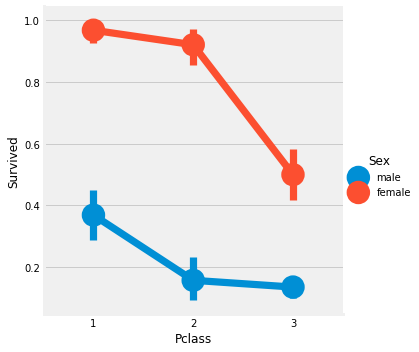

In [140]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=data)
plt.show()

In [141]:
print('Oldest Age of Passenger', data['Age'].max())
print('Youngest Age of Passenger', data['Age'].min())
print('Average Age of Passenger', data['Age'].mean())

Oldest Age of Passenger 80.0
Youngest Age of Passenger 0.42
Average Age of Passenger 29.69911764705882


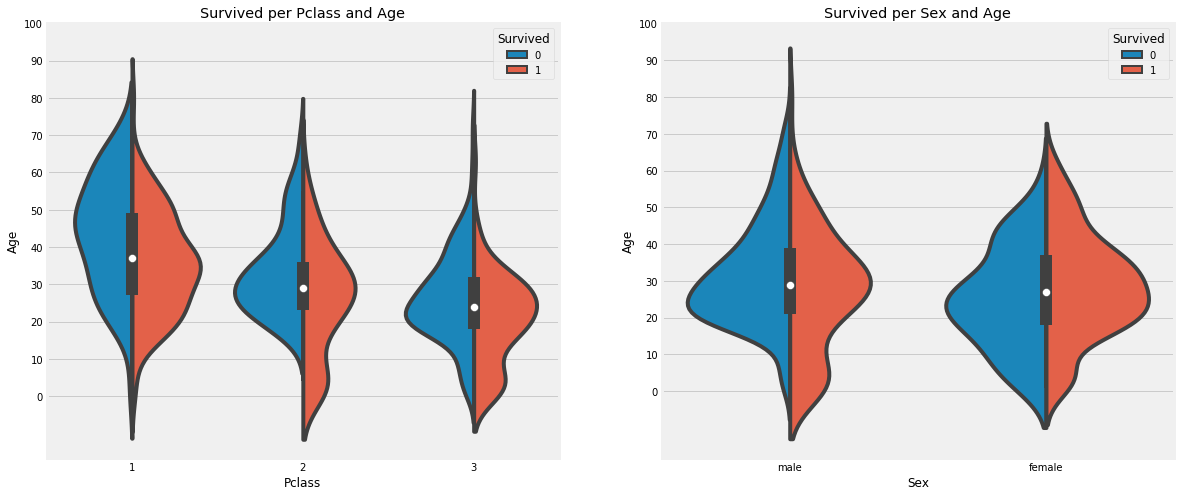

In [142]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot(x='Pclass', y='Age', hue='Survived', split=True, data=data, ax=ax[0])
ax[0].set_yticks(range(0, 110, 10))
ax[0].set_title('Survived per Pclass and Age')

sns.violinplot(x='Sex', y='Age', hue='Survived', split=True, data=data, ax=ax[1])
ax[1].set_yticks(range(0, 110, 10))
ax[1].set_title('Survived per Sex and Age')
plt.show()

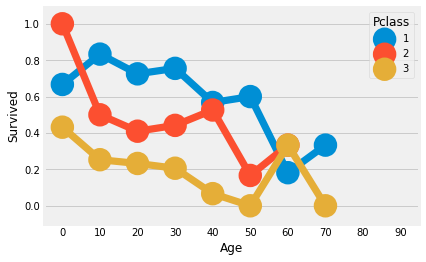

In [143]:
age_bins = range(0, 110, 10)
temp = data.copy()
temp['Age'] = pd.cut(temp['Age'], bins=age_bins, labels=age_bins[:-1])

sns.pointplot(x='Age', y='Survived', ci=None, hue='Pclass', data=temp)
plt.show()

There were 177 Null values in Age. So we should replace NaN with evaluted age.

We can do this by using Name. In each Name, there were prefix like 'Mr', 'Mrs'. If someone's name is Mr.Json, we can assign average age of 'Mr' group to Mr.Json.

In [144]:
data['Initial'] = 0
data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.') # extract saluations

In [145]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient()

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


There are some mis-spelled initials('Mlle', 'Mme'...).

Lets replace them 

In [146]:
data['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
    inplace=True)


In [147]:
data.groupby('Initial')['Age'].mean() # average age per Initial group

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

Filling NaN ages

In [148]:
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age'] = int(data.loc[(data.Initial=='Mr') & (data.Age.notnull())].Age.mean())
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age'] = int(data.loc[(data.Initial=='Mrs') & (data.Age.notnull())].Age.mean())
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age'] = int(data.loc[(data.Initial=='Master') & (data.Age.notnull())].Age.mean())
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age'] = int(data.loc[(data.Initial=='Miss') & (data.Age.notnull())].Age.mean())
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age'] = int(data.loc[(data.Initial=='Other') & (data.Age.notnull())].Age.mean())

In [149]:
data.Age.isnull().any() # no null values in Age

False

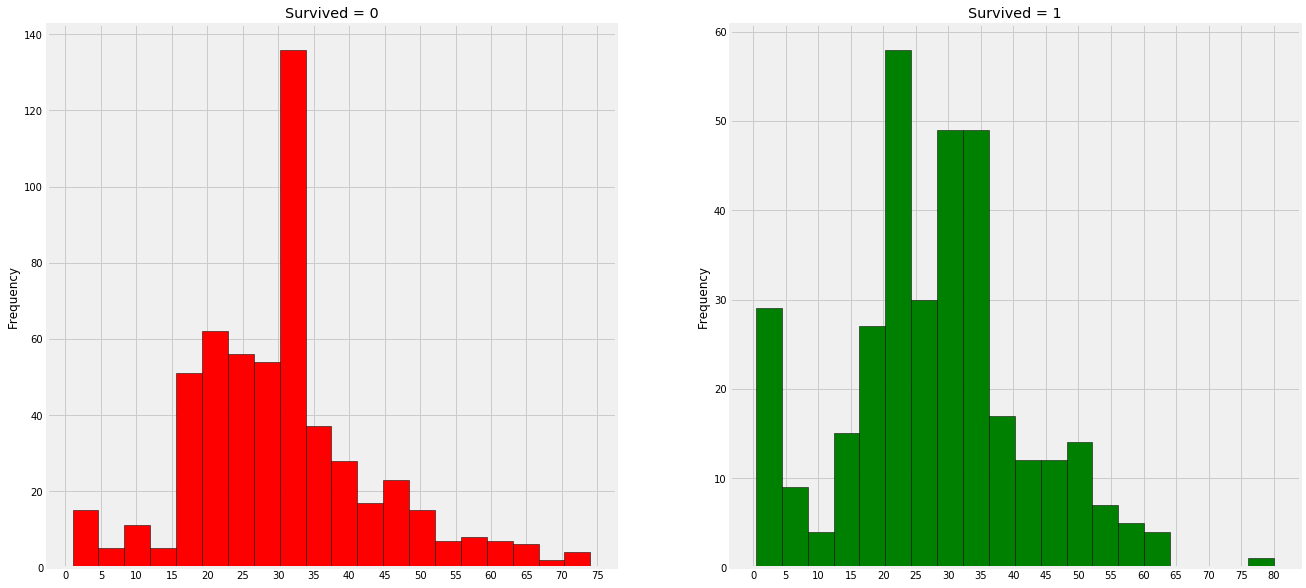

In [150]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_title('Survived = 0')
ax[0].set_xticks(range(0, 100, 5))
data[data['Survived']==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')

ax[1].set_title('Survived = 1')
ax[1].set_xticks(range(0, 100, 5))
data[data['Survived']==1].Age.plot.hist(ax=ax[1], bins=20, edgecolor='black', color='green')

plt.show()

### Observations
- Women and Child First
- Maximun number of death were in the age group 30-35

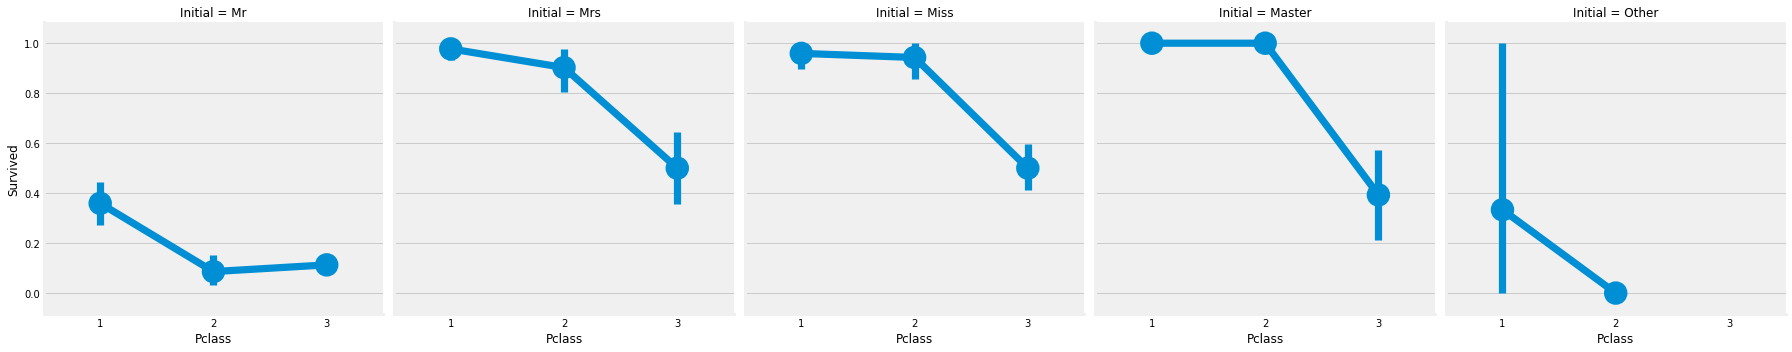

In [151]:
sns.factorplot('Pclass', 'Survived', col='Initial', data=data)
plt.show() # Women and Child First policy holds irrespective of Pclass

In [152]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient()

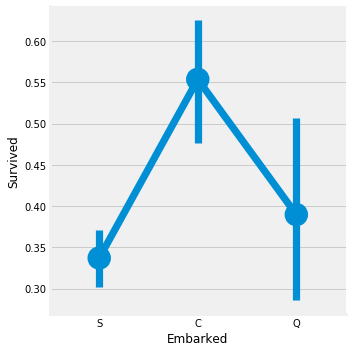

In [153]:
# Chanced for survival per Embarkation => 'C' survived most
sns.factorplot('Embarked', 'Survived', data=data)
plt.show()

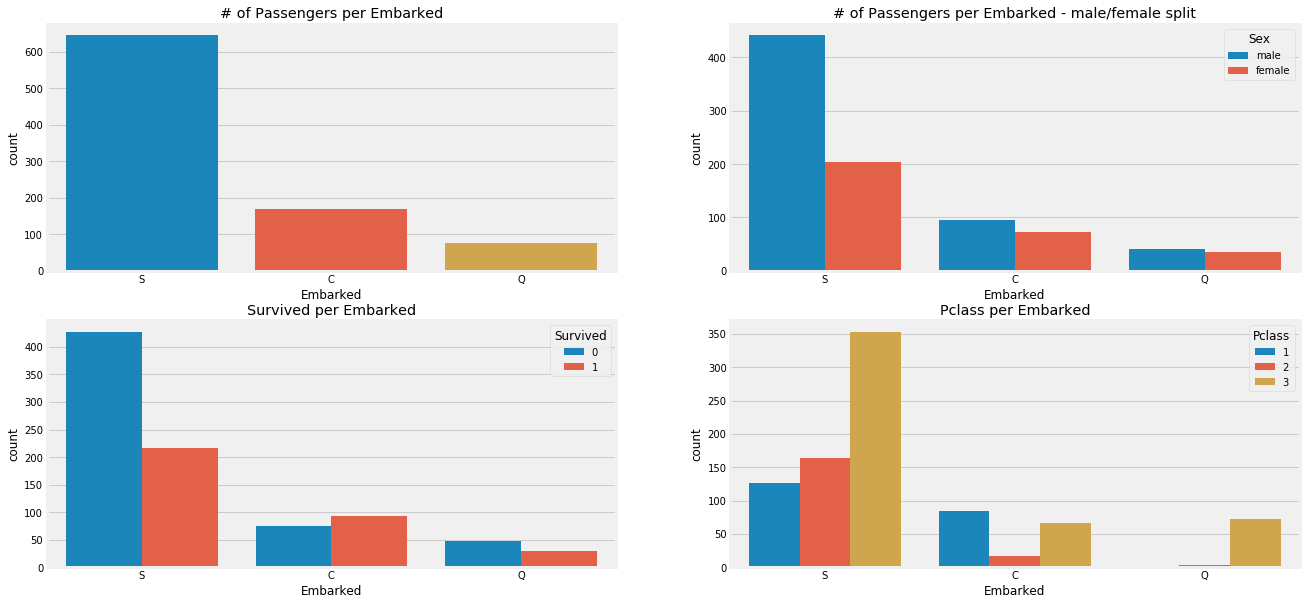

In [154]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].set_title('# of Passengers per Embarked')
sns.countplot('Embarked', data=data, ax=ax[0, 0])

ax[0, 1].set_title('# of Passengers per Embarked - male/female split')
sns.countplot('Embarked', hue='Sex', data=data, ax=ax[0, 1])

ax[1, 0].set_title('Survived per Embarked')
sns.countplot('Embarked', hue='Survived', data=data, ax=ax[1, 0])

ax[1, 1].set_title('Pclass per Embarked')
sns.countplot('Embarked', hue='Pclass', data=data, ax=ax[1, 1])

plt.show()

### Observations
- Most of people embarked from 'S'
- Survival rate: C > Q > S

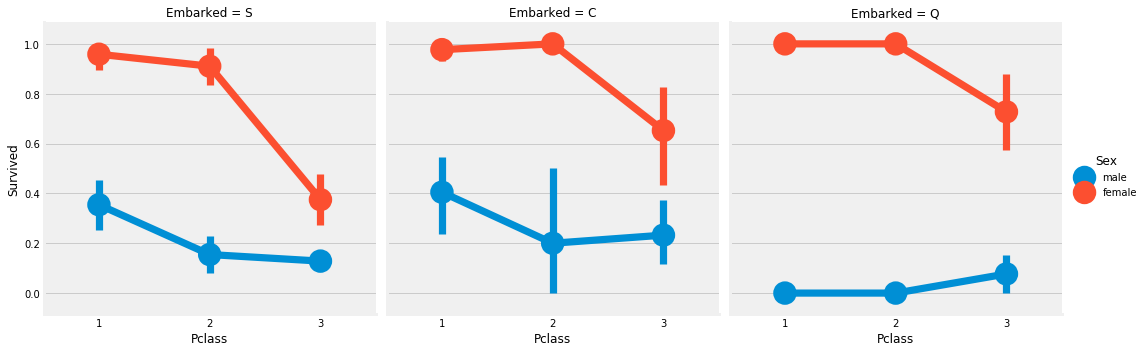

In [155]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=data)
plt.show()

### Observations
- Women in Pclass1 and Pclass2 were almost survived irrespective of Embarked
- Port 'S' looks unlucky for Pclass3
- Almost every men from port 'Q' did not survived

In [156]:
# Because maximum passenger embarked from 'S', let's replace NaN to 'S'
data['Embarked'].fillna('S', inplace=True)

In [157]:
data.Embarked.isnull().any() # no NaN values in Embarked

False

In [158]:
# SibSp means whether passenger was with his/her family or alone
pd.crosstab(data.SibSp, data.Survived).style.background_gradient()

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


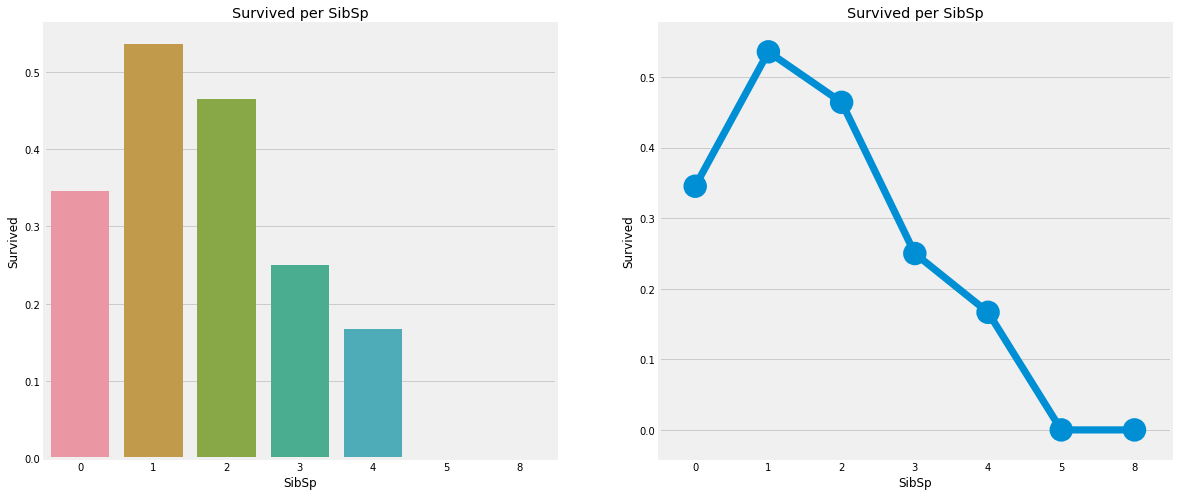

In [159]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].set_title('Survived per SibSp')
sns.barplot(x='SibSp', y='Survived', ci=None, data=data, ax=ax[0])

ax[1].set_title('Survived per SibSp')
sns.factorplot(x='SibSp', y='Survived', ci=None, data=data, ax=ax[1])

plt.close(2) # close redundant blank plot
plt.show()

In [160]:
pd.crosstab(data.SibSp, data.Pclass).style.background_gradient()

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


### Observations
- People whose SibSp > 3 were all in Pclass3 and died
- Survival rate decreases with SibSp because one would save his/her family rather then him/herself

In [161]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient()

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


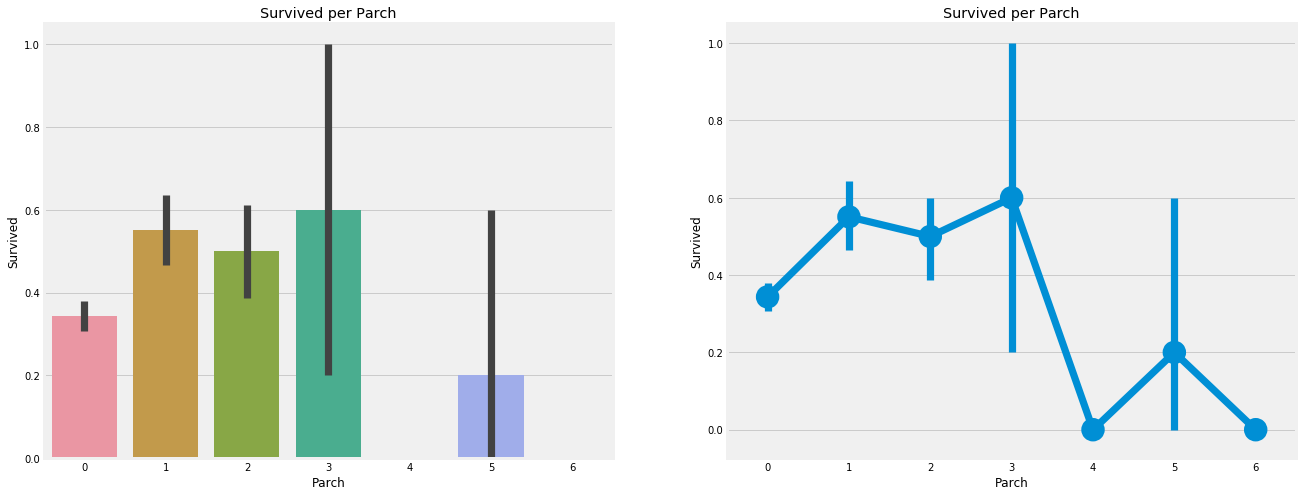

In [162]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].set_title('Survived per Parch')
sns.barplot(x='Parch', y='Survived', data=data, ax=ax[0])

ax[1].set_title('Survived per Parch')
sns.factorplot(x='Parch', y='Survived', data=data, ax=ax[1])

plt.close(2)
plt.show()

### Observations
- Large family were in Pclass3
- Same with SibSp

In [163]:
print('Highest fare was:', data['Fare'].max())
print('Lowest fare was:', data['Fare'].min())
print('Average fare was:', data['Fare'].mean())

Highest fare was: 512.3292
Lowest fare was: 0.0
Average fare was: 32.204207968574636


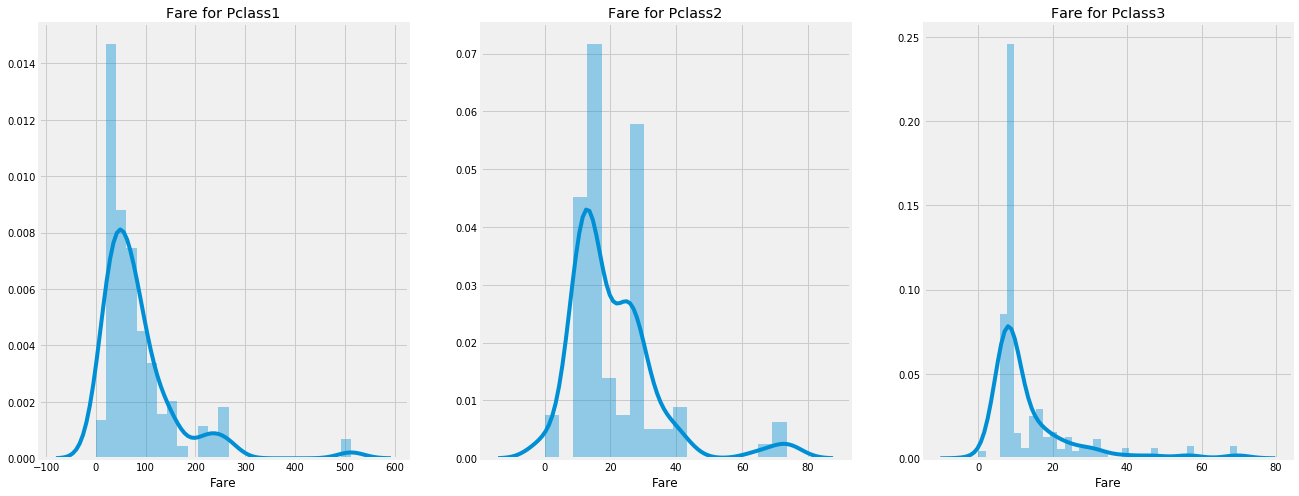

In [164]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].set_title('Fare for Pclass1')
sns.distplot(data[data['Pclass']==1].Fare, ax=ax[0])

ax[1].set_title('Fare for Pclass2')
sns.distplot(data[data['Pclass']==2].Fare, ax=ax[1])

ax[2].set_title('Fare for Pclass3')
sns.distplot(data[data['Pclass']==3].Fare, ax=ax[2])

plt.show()

### Correlations between features

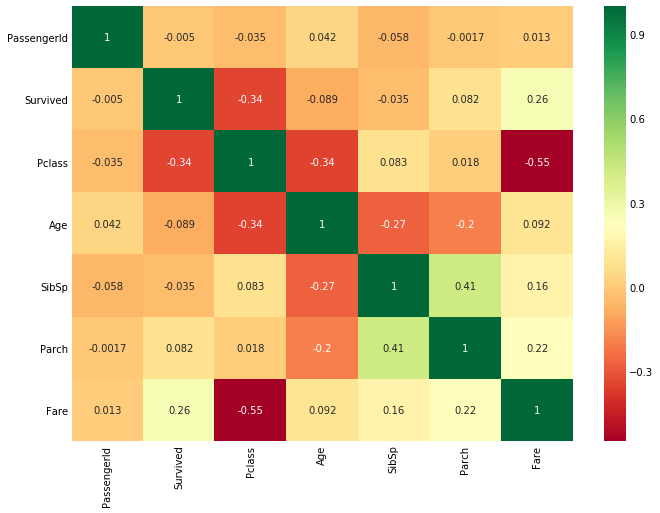

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.042323 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.088744 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.344849  0.083081  0.018443   
Age             0.042323 -0.088744 -0.344849  1.000000 -0.268357 -0.195021   
SibSp          -0.057527 -0.035322  0.083081 -0.268357  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.195021  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.092132  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.092132  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


In [165]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

print(data.corr()) # correlation matrix

### About correlation
- Only numeric features can have correaltion(Alpahbet, String cannot have correaltion normarlly)
- If increase in feature A leads to increase in feature B, then they are positively correlated.
- Value 1 means perfect positive correaltion
- If increase in feature A leads to decrease in feature B, then they are negatively correlated.
- Value -1 means perfect negative correlation

## 4. Feature Engineering and Data Cleaning
Whenever we are given a dataset with features, it is not necessary that all the features will be important. There maybe be many redundant features which should be eliminated. Also we can get or add new features by observing or extracting information from other features.

An example would be getting the Initals feature using the Name Feature. Lets see if we can get any new features and eliminate a few. Also we will tranform the existing relevant features to suitable form for Predictive Modeling.

### Problem with Age feature
Because Age is continuous feature, there can be many values. It means that we cannot group by Age.

So we can convert continuous 'Age' to categorical 'Age band'.

We can do this by binning or normalization.

In this case, we will use binning. The maximum Age is 80, so lets split Age band with range(0, 80, 5) which is 16 bins.


In [166]:
data['Age_band'] = 0
data.loc[data['Age']<=16, 'Age_band'] = 0
data.loc[(data['Age']>16) & (data['Age']<=32), 'Age_band'] = 1
data.loc[(data['Age']>32) & (data['Age']<=48), 'Age_band'] = 2
data.loc[(data['Age']>48) & (data['Age']<=64), 'Age_band'] = 3
data.loc[(data['Age']>64) & (data['Age']<=80), 'Age_band'] = 4
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2


In [167]:
# number of passengers in each Age_band
data['Age_band'].value_counts().to_frame().style.background_gradient()

,Age_band
1,502
2,205
0,104
3,69
4,11


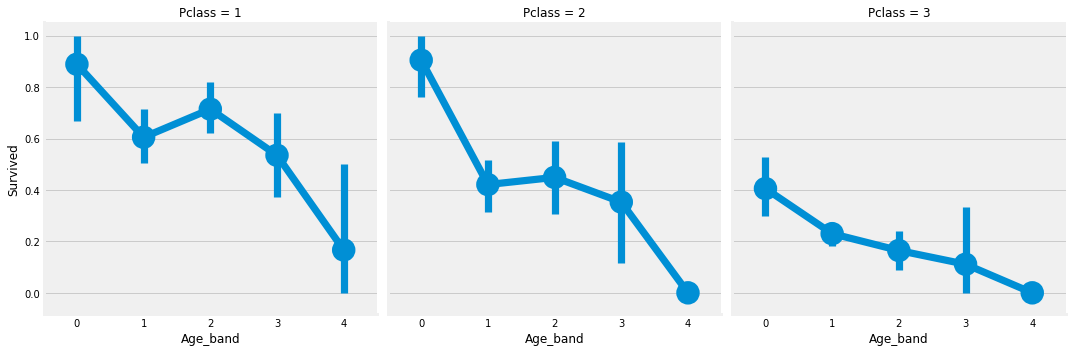

In [168]:
sns.factorplot(x='Age_band', y='Survived', data=data, col='Pclass')
plt.show()

### Observation
- Survival rate decreases as Age_band increases

### Family_Size and Alone
- Family_Size = SibSp + Parch
- Alone: boolean

In [169]:
data['Family_Size'] = 0
data['Family_Size'] = data['SibSp'] + data['Parch']
data['Alone'] = 0
data.loc[data['Family_Size']==0, 'Alone'] = 1

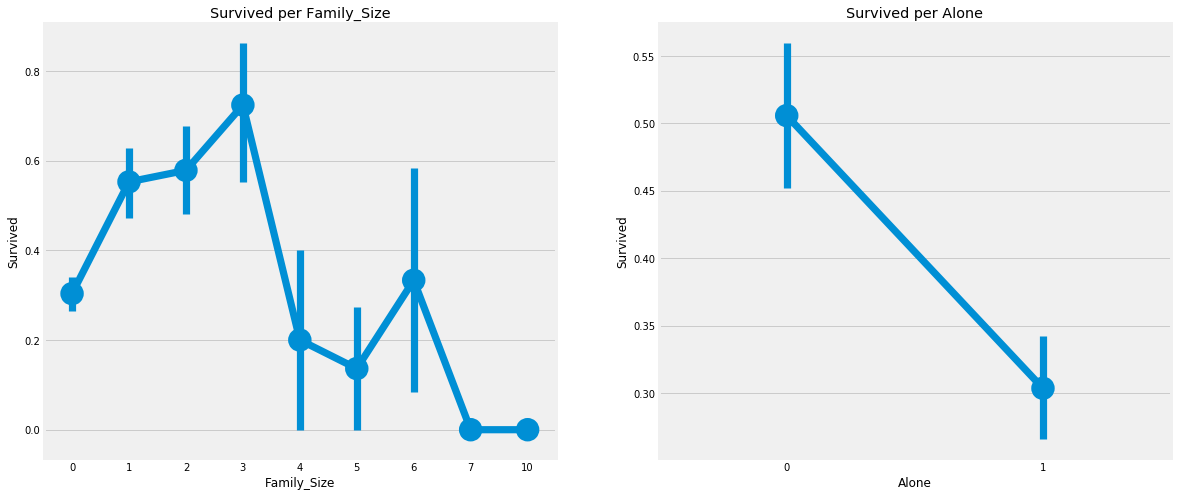

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].set_title('Survived per Family_Size')
sns.factorplot(x='Family_Size', y='Survived', data=data, ax=ax[0])

ax[1].set_title('Survived per Alone')
sns.factorplot(x='Alone', y='Survived', data=data, ax=ax[1])

plt.close(2)
plt.close(3)
plt.show()

### Observations
- Family_Size=0 <=> Alone=1
- Family_Size=0 or Family_Size>3 has low survival rate

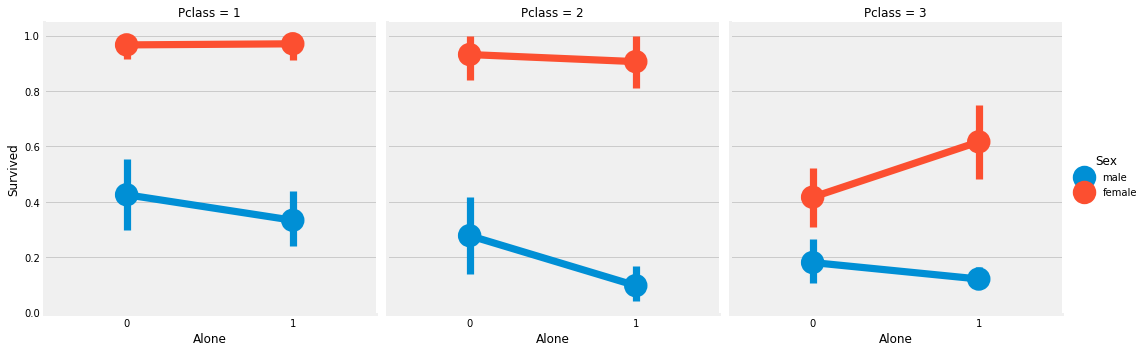

In [171]:
sns.factorplot(x='Alone', y='Survived', hue='Sex', col='Pclass', data=data)
plt.show()

### Observations
- Being alone is harmful except the case: Female in Pclass3

### Fare_Range
- Since Fare is continuous feature, we sholud convert it to ordinal.
- Use `pandas.qcut`

In [172]:
data['Fare_Range'] = pd.qcut(data['Fare'], 4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient()

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


### Observation
- Chances of Survival increases as Fare_Range increases
- Convert Fare_Range to singleton values same in 'Age_Band'

In [173]:
data['Fare_Cat'] = 0
data.loc[data['Fare']<=7.91, 'Fare_Cat'] = 0
data.loc[(data['Fare']>7.91) & (data['Fare']<=14.454), 'Fare_Cat'] = 1
data.loc[(data['Fare']>14.454) & (data['Fare']<=31.0), 'Fare_Cat'] = 2
data.loc[(data['Fare']>31.0) & (data['Fare']<=512.329), 'Fare_Cat'] = 3

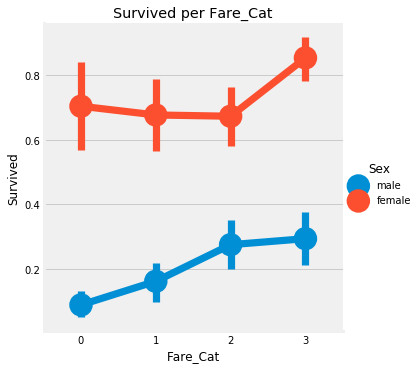

In [174]:
sns.factorplot(x='Fare_Cat', y='Survived', hue='Sex', data=data)
plt.title('Survived per Fare_Cat')
plt.show()

## 5. Convert String values into Numeric

In [175]:
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace=True)


In [176]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band,Family_Size,Alone,Fare_Range,Fare_Cat
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,1,0,"(-0.001, 7.91]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,2,1,0,"(31.0, 512.329]",3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,2,1,0,1,"(7.91, 14.454]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,2,1,0,"(31.0, 512.329]",3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,2,0,1,"(7.91, 14.454]",1


## 6. Dropping unneeded features
- Name: we will not use because it cannot be converted to any categorical value(also numeric value)
- Age: replace this with 'Age_band'
- Ticket: Same with Name
- Fare: replace this with 'Fare_Cat'
- Cabin: A lot of Null values and many passengers have multiple cabins
- Fare_Range: we will use 'Fare_Cat'
- PassengerId: Same with Name

In [177]:
data.drop(['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Fare_Range', 'PassengerId'], axis=1, inplace=True)


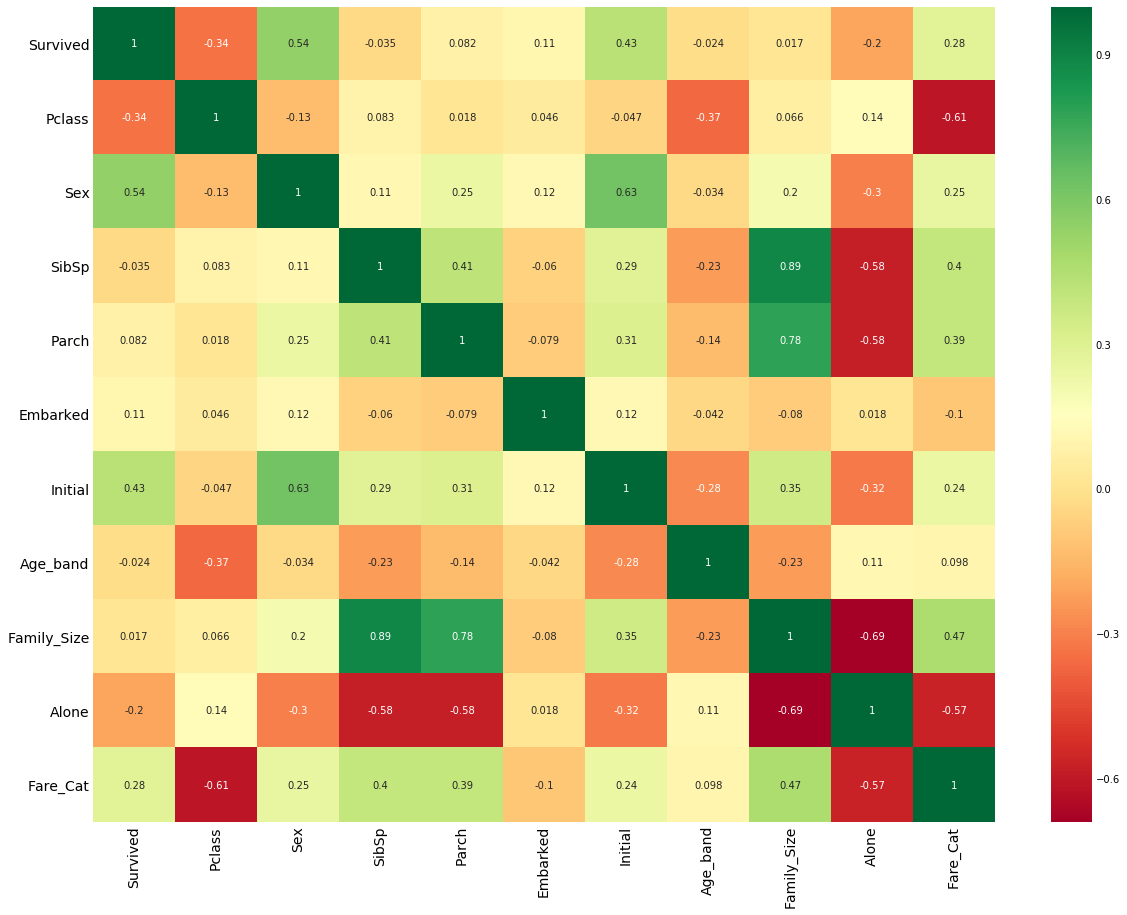

In [178]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Observation
- SibSp/Parch and Family_Size has strong positive correlation

## 7. Predictive Modeling
- Logistic Regression
- Support Vector Machine(Linear, radial)
- Random Forest
- K-Nearest Neighbours
- Naive Bayes
- Decision Tree

In [180]:
# import required ML packages
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn import svm # support vector machine
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.neighbors import KNeighborsClassifier # k-nearest neighbour
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.model_selection import train_test_split # train test split
from sklearn import metrics # accuracy measure
from sklearn.metrics import confusion_matrix # confusion matrix